<a href="https://colab.research.google.com/github/Zunuoh/Dengue-Fever-Prediction/blob/main/New_Dengue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('climate_disease_dataset.csv')
df.head()

,year,month,country,region,avg_temp_c,precipitation_mm,air_quality_index,uv_index,malaria_cases,dengue_cases,population_density,healthcare_budget
0,2000,1,Palestinian Territory,Central,28.132468,152.083870,110.487231,12.000000,53,145,113,1068
1,2000,2,Palestinian Territory,Central,30.886500,119.591418,83.467928,12.000000,132,48,113,1068
2,2000,3,Palestinian Territory,Central,31.366433,95.876124,93.095292,12.000000,34,80,113,1068
3,2000,4,Palestinian Territory,Central,28.481870,175.315731,105.530192,9.395894,23,133,113,1068
4,2000,5,Palestinian Territory,Central,26.890370,191.445990,60.205979,9.935726,39,74,113,1068


In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,34560.000,2011.500,6.922,2000.000,2005.750,2011.500,2017.250,2023.000
month,34560.000,6.500,3.452,1.000,3.750,6.500,9.250,12.000
avg_temp_c,34560.000,20.395,8.411,-2.557,14.404,20.352,26.343,44.584
precipitation_mm,34560.000,192.668,90.504,0.000,124.641,195.315,260.148,485.704
air_quality_index,34560.000,43.788,33.080,0.000,15.323,40.686,68.402,168.848
uv_index,34560.000,10.211,1.937,0.871,8.921,10.761,12.000,12.000
malaria_cases,34560.000,70.520,46.131,0.000,32.000,69.000,107.000,201.000
dengue_cases,34560.000,75.941,37.324,0.000,48.000,76.000,104.000,181.000
population_density,34560.000,266.900,136.001,50.000,136.250,277.500,384.750,498.000
healthcare_budget,34560.000,2764.650,1418.119,205.000,1435.500,2859.000,3996.750,4969.000


In [4]:
df.isnull().sum()

,0
year,0
month,0
country,0
region,0
avg_temp_c,0
precipitation_mm,0
air_quality_index,0
uv_index,0
malaria_cases,0
dengue_cases,0


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  object 
 3   region              34560 non-null  object 
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  int64  
 9   dengue_cases        34560 non-null  int64  
 10  population_density  34560 non-null  int64  
 11  healthcare_budget   34560 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.2+ MB


In [7]:
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                34560 non-null  int64   
 1   month               34560 non-null  int64   
 2   country             34560 non-null  category
 3   region              34560 non-null  category
 4   avg_temp_c          34560 non-null  float64 
 5   precipitation_mm    34560 non-null  float64 
 6   air_quality_index   34560 non-null  float64 
 7   uv_index            34560 non-null  float64 
 8   malaria_cases       34560 non-null  int64   
 9   dengue_cases        34560 non-null  int64   
 10  population_density  34560 non-null  int64   
 11  healthcare_budget   34560 non-null  int64   
dtypes: category(2), float64(4), int64(6)
memory usage: 2.7 MB


In [9]:
df = pd.get_dummies(df, columns=['country', 'region'], drop_first=True)

In [10]:
X = df.drop(['dengue_cases', 'year'], axis=1)
y = df['dengue_cases']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
country_columns = [col for col in df.columns if col.startswith('country_')]
country_cases = df[country_columns].multiply(df['dengue_cases'], axis=0).sum()
country_cases = country_cases.reset_index()
country_cases.columns = ['Country', 'Total Cases']


region_columns = [col for col in df.columns if col.startswith('region_')]
region_cases = df[region_columns].multiply(df['dengue_cases'], axis=0).sum()
region_cases = region_cases.reset_index()
region_cases.columns = ['Region', 'Total Cases']

/tmp/ipython-input-12-187660578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')


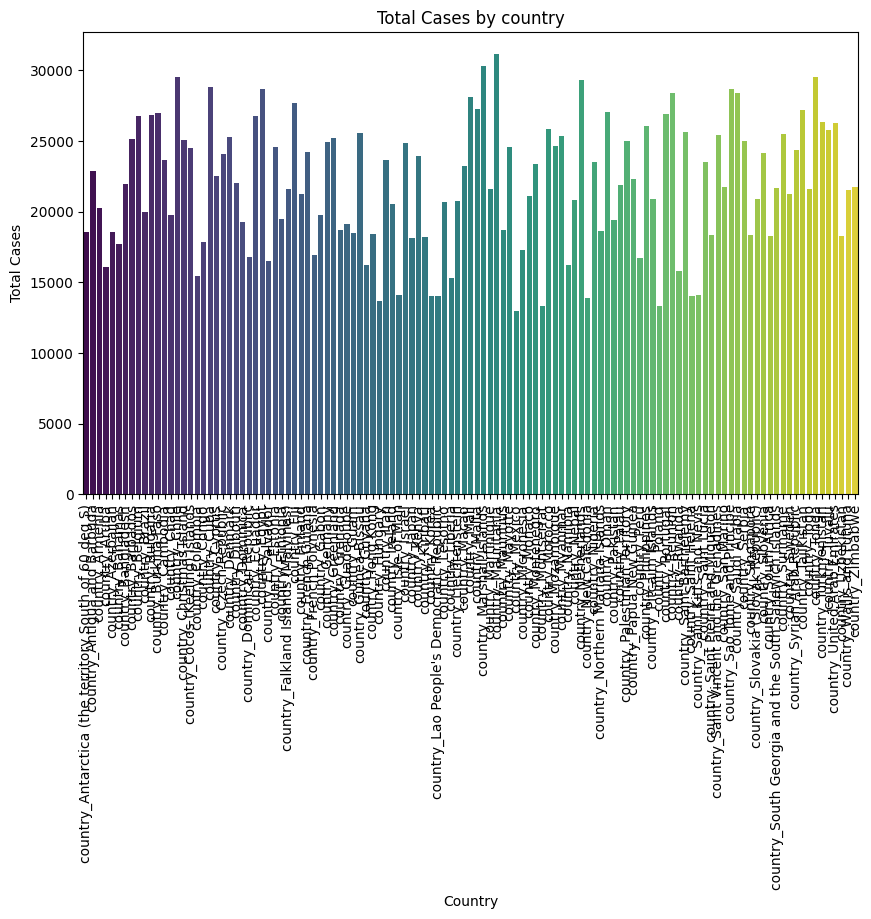

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Total Cases', data=country_cases, palette='viridis')
plt.title('Total Cases by country')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

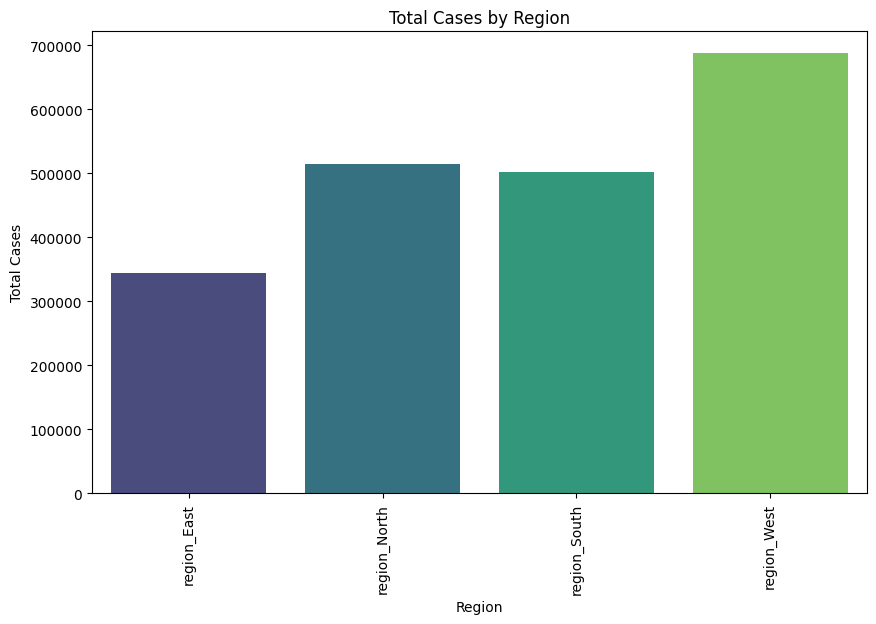

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Cases', data=region_cases, palette='viridis')
plt.title('Total Cases by Region')
plt.xlabel('Region')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.show()

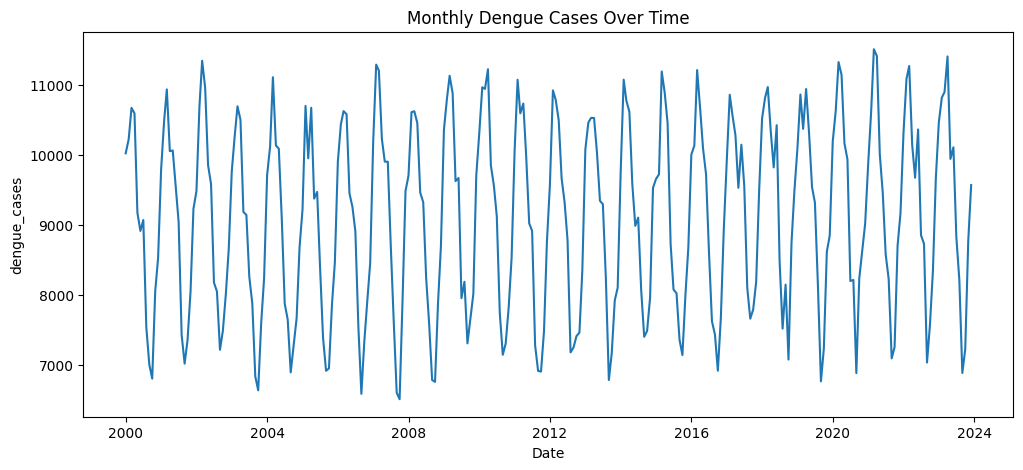

In [14]:
monthly = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Date', y='dengue_cases')
plt.title("Monthly Dengue Cases Over Time")
plt.show()

## **FEATURE ENGINEERING**

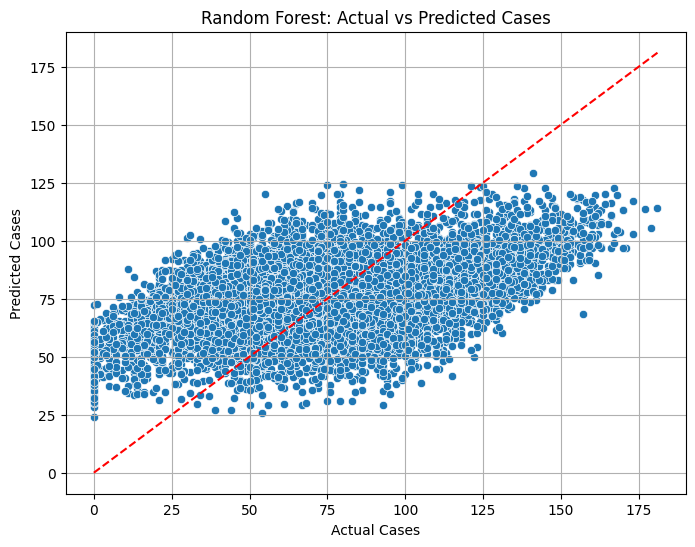

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Random Forest: Actual vs Predicted Cases")
plt.grid(True)
plt.show()

## **COMPARE PROVINCE CASES TO FACTORS**

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

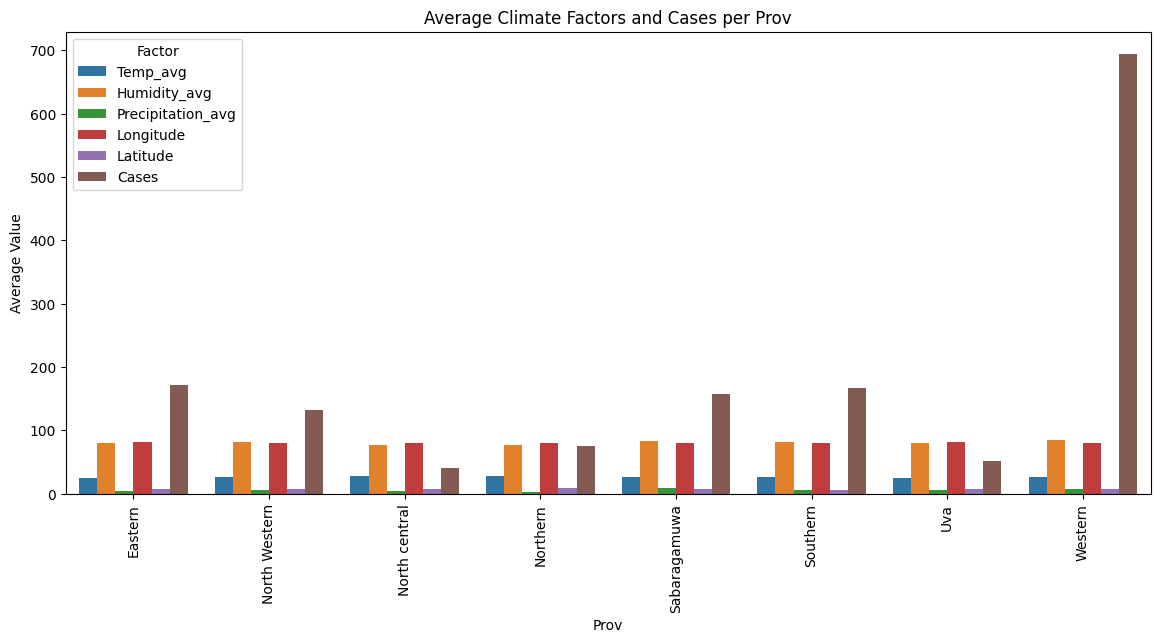

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Longitude', 'Latitude', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

### **COMPARE DISTRICT CASES TO FACTORS**

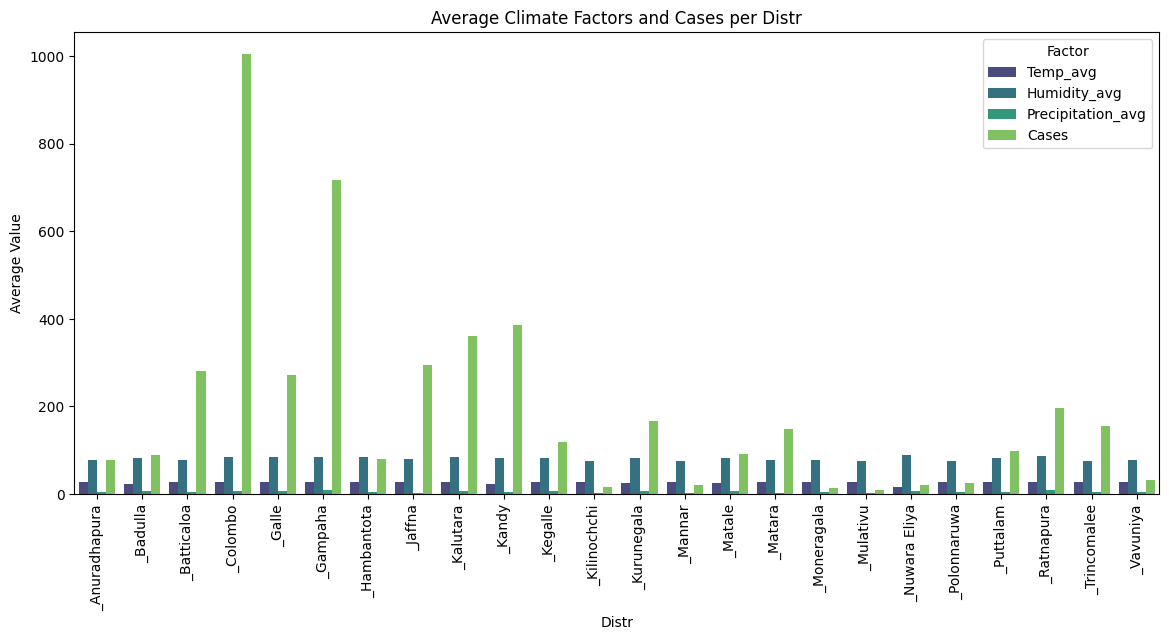

In [ ]:
df['Distr'] = df[district_columns].idxmax(axis=1).str.replace('District', '')
factors = df.groupby('Distr')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Distr', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Distr', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Distr')
plt.xticks(rotation=90)
plt.show()

### **CORRELATION HEATMAP**

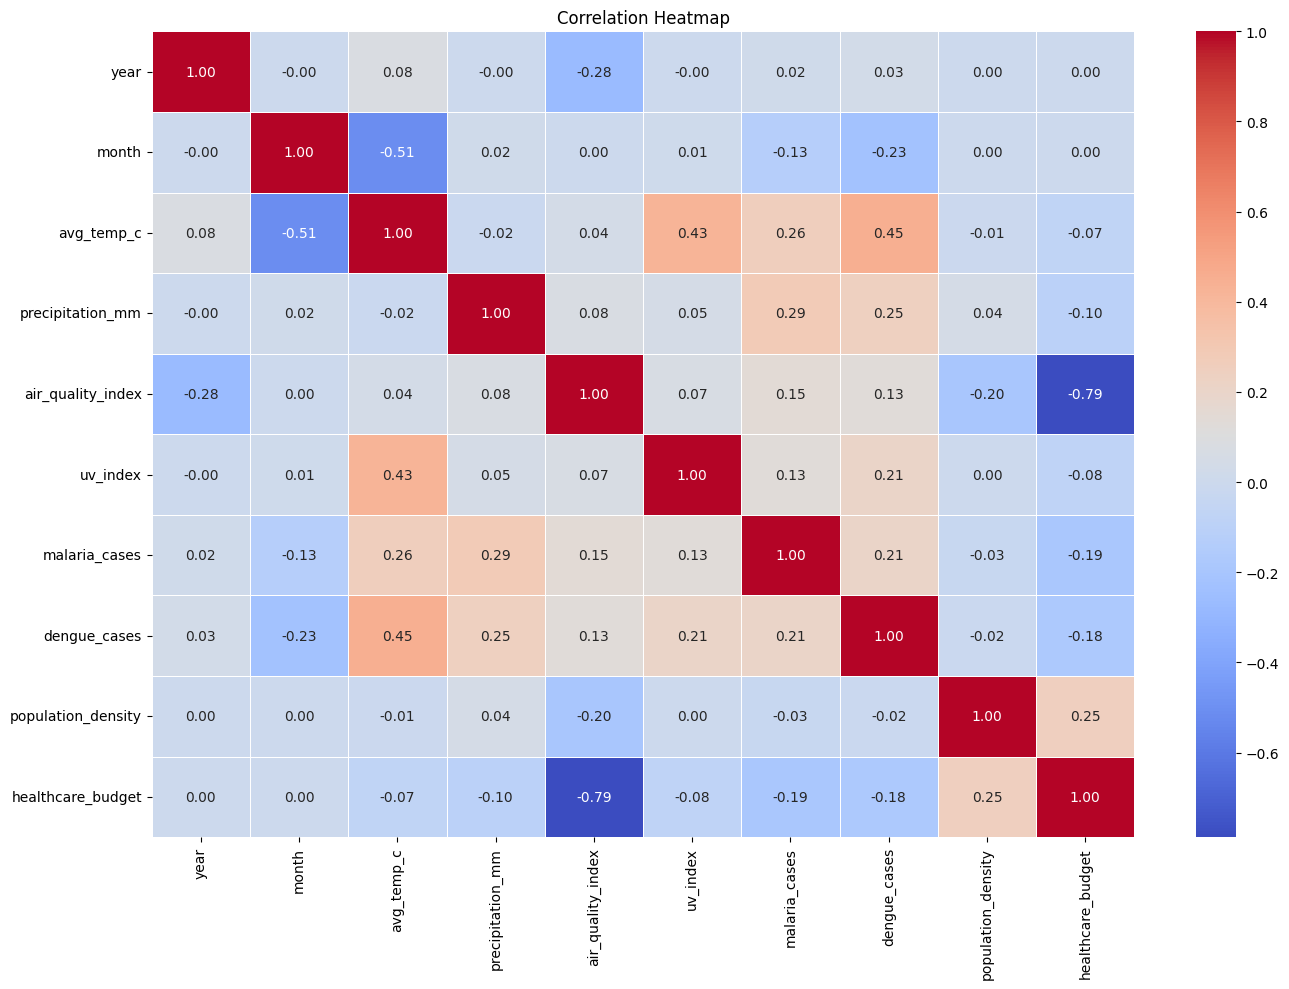

In [11]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.select_dtypes(include='number')  # Keep only numeric columns

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import statsmodels.api as sm

# 1. Select your predictor and target
X = df[['avg_temp_c']]  # Predictor: average temperature
y = df['dengue_cases']  # Target: dengue cases

# 2. Add a constant term for the intercept
X = sm.add_constant(X)

# 3. Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# 4. Print the summary for p-value, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8837.
Date:                Mon, 07 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:30:47   Log-Likelihood:            -1.7020e+05
No. Observations:               34560   AIC:                         3.404e+05
Df Residuals:                   34558   BIC:                         3.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0995      0.470     74.687      0.0

Results above for p value is <0.05 so temperature is a factor